In [487]:
import os
import time
import json

import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
from network_files import FasterRCNN, FastRCNNPredictor, AnchorsGenerator
from backbone import resnet50_fpn_backbone, MobileNetV2
import numpy as np

In [488]:
def create_model(num_classes):
    backbone = resnet50_fpn_backbone(norm_layer=torch.nn.BatchNorm2d)
    model = FasterRCNN(backbone=backbone, num_classes=num_classes, rpn_score_thresh=0.5)
    return model
def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()

In [498]:
ind_dic = {
    1:"aeroplane",
    2:"bicycle",
    3:"bird",
    4:"boat",
    5:"bottle",
    6:"bus",
    7:"car",
    8:"cat",
    9:"chair",
    10:"cow",
    11:"diningtable",
    12:"dog",
    13:"horse",
    14:"motorbike",
    15:"person",
    16:"pottedplant",
    17:"sheep",
    18:"sofa",
    19:"train",
    20:"tvmonitor"
}
testclass_dict = {
    "aeroplane": 1,
    "bicycle": 2,
    "bird": 3,
    "boat": 4,
    "bottle": 5,
    "bus": 6,
    "car": 7,
    "cat": 8,
    "chair": 9,
    "cow": 10,
    "diningtable": 11,
    "dog": 12,
    "horse": 13,
    "motorbike": 14,
    "person": 15,
    "pottedplant": 16,
    "sheep": 17,
    "sofa": 18,
    "train": 19,
    "tvmonitor": 20
}
# test_classes = ['aeroplane','bicycle','bus','car','person','train','boat','horse','motorbike']
test_classes = ['car','person','bus']
# testclass_dict = {'aeroplane':0,'bicycle':1,'bus':2,'car':3,'person':4,'train':5,'boat':6,'cat':7,'horse':8,'motorbike':9,'dog':10}
# test_classes = ["aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow","diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa","train","tvmonitor"]

# global_len = [169,226,297,111,27,259,299,400,232,116,89,400,244,294,400,80,125,115,141,170]
global_len = 20*[150]

In [464]:
# def res_item(boxes, classes, scores, ind_dic, box_thresh: float = 0.1):
#     idxs = np.greater(scores, box_thresh)
#     labels = []
#     cla = classes[idxs]
#     if len(cla) == 0:
#         labels.append("Empty")
#         greatest = None
#     if len(cla) != 0:
#         idx = np.argmax(scores)
#         for p in cla:
#             lb = ind_dic[p]
#             labels.append(lb)
#         labels = np.array(labels)
#         greatest = ind_dic[classes[idx]]
#     return labels,greatest
def res_item(boxes, classes, scores, ind_dic, box_thresh: float = 0.1):
    idxs = np.greater(scores, box_thresh)
    box = boxes[idxs]
    clas = classes[idxs]
    labels = []
    num_idx = sum(idxs)
    for i in range(num_idx):
        box_size = (box[i,0]-box[i,2])*(box[i,1]-box[i,3])
        if box_size > 7500:
            labels.append(ind_dic[clas[i]])
    return labels

In [465]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))
model = create_model(num_classes=21)
weights_path = "./save_weights/p-0.pth"
assert os.path.exists(weights_path), "{} file dose not exist.".format(weights_path)
weights_dict = torch.load(weights_path, map_location='cpu')
weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
model.load_state_dict(weights_dict)
model.to(device)
label_json_path = './pascal_voc_classes.json'
assert os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
with open(label_json_path, 'r') as f:
    class_dict = json.load(f)
category_index = {str(v): str(k) for k, v in class_dict.items()}

using cuda:0 device.


In [503]:
num_classes = len(test_classes)
print(num_classes)
comp_mat = np.zeros((num_classes,num_classes+2))
global_len = [150]*num_classes
for i in range(num_classes):    
    tar_class = test_classes[i]
    print("Category:",tar_class)
    path = "C:/Users/Dalei/Desktop/Mywork/test_all/{}/".format(tar_class)
    numb = global_len[i]
    for k in range(numb):
        original_img = Image.open(path+str(k)+".jpg")
        data_transform = transforms.Compose([transforms.ToTensor()])
        img = data_transform(original_img)
        img = torch.unsqueeze(img, dim=0)
        model.eval() 
        with torch.no_grad():
            img_height, img_width = img.shape[-2:]
            init_img = torch.zeros((1, 3, img_height, img_width), device=device)
            model(init_img)
            predictions = model(img.to(device))[0]
            predict_boxes = predictions["boxes"].to("cpu").numpy()
            predict_classes = predictions["labels"].to("cpu").numpy()
            predict_scores = predictions["scores"].to("cpu").numpy()
            labels = res_item(predict_boxes, predict_classes, predict_scores, ind_dic)
        if len(labels) == 0:
            ind = num_classes
        elif tar_class in labels:
            ind = np.where(np.array(test_classes)==tar_class)[0][0]
        elif labels[0] in test_classes:
            ind = np.where(np.array(test_classes)==labels[0])[0][0] 
        else:
            ind = num_classes+1
        comp_mat[i,ind] += 1
    comp_mat[i,:]=comp_mat[i,:]/np.sum(comp_mat[i,:])
#     print(comp_mat[i,:])

3
Category: car
Category: person
Category: bus


In [504]:
print(num_classes)

3


In [505]:
# a = np.load("./Npy/multi11_comp_nn.npy")
# b = np.load("./Npy/multi_comp_eig.npy")
a_s = np.sum(np.diag(comp_mat))
# b_s = np.sum(np.diag(b)[1:])

In [506]:
a_s/num_classes

0.5844444444444444

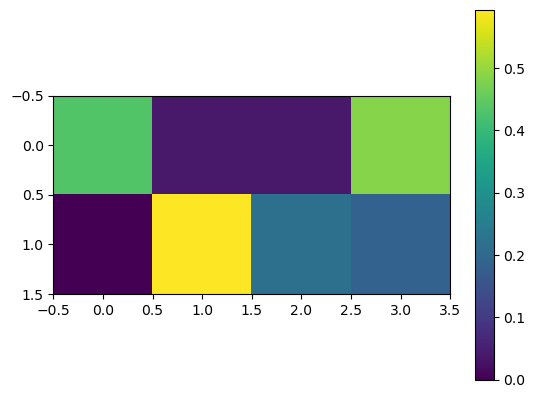

In [495]:
plt.imshow(comp_mat)
plt.colorbar()

In [472]:
np.save('multi11_comp_nn_box_11_modi.npy',comp_mat)

In [481]:
A = np.load("./Npy/multi_comp_eig.npy")

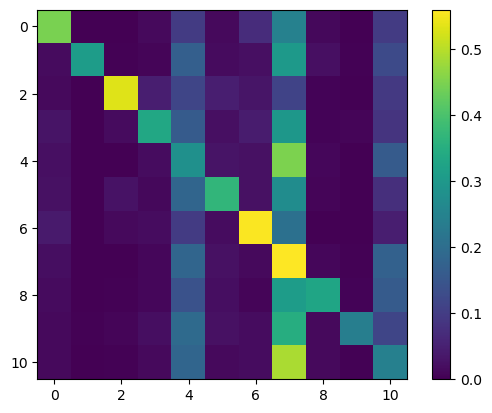

In [476]:
plt.imshow(a)
plt.colorbar()